In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
from plotting_utils import *
from model_test_cases import *


Title
- Abstract
- Introduction
- Materials and methods or Description of the Model - Results
- Discussion
- Conclusions and Summary (optional)
- Acknowledgements (optional) - References
- Appendix (optional)


# A model for two mice in a small cage

## Introduction

## Problem statement: Two mice in a cage

The problem given to us was:

P1. We have two mice in a cage (in a 2-D or 1-D field).
P2. They don't like each other.
P3. Food is present in one given spot in the cage.
P4. There is only enough space for one mouse to eat at a time.
P5. They need to reproduce.
P6. They don't reproduce where they eat.
P7. After being full, mice don't find the feeding spot that attractive anymore.

We are interested in trajectories of the two mice.

## Assumptions

The problem description brings many details that can or should be modeled. As a consequence, a model
taking everything into consideration should be quite complicated.
For exemplification, however, we want to have a model that takes into consideration a couple of key aspects
of the problem and ignores the rest.

Therefore, I will ignore some aspects specified in the problem description and will generalize over some biological
details.

### A1. The cage

I will assume the mice move inside idealized cages with infinitely high walls such that the mice are not influenced
in any ways by the outside world.
Thus, the system is closed and, therefore, it's state evolution depends only on variables that can be found inside
the cage.

Also, very important, I will assume one can observe the mice from above in an idealized way.
This means we always have access to their exact position and this reading is done free of any noise.

### A2. Biological variability of the mice physiology

I will assume that the actual physical biology of the mice is irrelevant for the problem at hand.
One could look for biologically plausible movement model of the mouse, in which arms, legs joins, body and head geometry
are considered. However, I do not expect that these details can improve the quality of the desired outputted trajectories
and I will simply ignore these.

Therefore, I will idealize the 2 mice inside a cage to point particles that obey a system of coupled and nonlinear
equations.

This way a lot of complexity coming from a biologically plausible movement model of the mice is avoided.

### A3. Movement of the mice

The problem does not express it explicitly, but I will assume that mice usually like exploring their
environments.

### A4. Feeding spot

I will assume food is present in abundance for the mice. Because the problem does not state anything more specifically,
I will assume there is no feeding schedule or any fixed time window in which feeding can be done. As a consequence,
infinite amount of food will be **always** present in the cage. This is why, when a  mouse feeds, he does not need
to "consume" any resource and should he want directly after to feed again, enough food is present.

I will assume the mice will be able to access the food if they are close enough to the feeding spot. Also, the feeding
is done instantly. I.e. if a mouse in the proximity of the feeding spot, close enough, the mouse will simply
have instant access to plenty of food to feel full directly.

### A5. Mating

One could, as with the biological plausible modelling of the movement, find a biologically plausible modelling
for how attraction or repulsion works in mice.

I will not do that and I chose to model the mating period of the mice very abstractly, with one assumption.
I will assume that the closer the mice are to each other, the more aroused they are by the presence of the
other mouse.
I will assume that mice do not keep exact track of time to detect regularities of mating periods.
Because mice have a more developed sense of smell that vision, I will assume a diffusion process of
pheromones is driving the signal of mating availability.
I will abstract away, though, the exact diffusion of the pheromones in a similar way I idealized mice to point particles.
TODO: Do it better



### Details ignored from the problem description

#### 1. There is only enough space for one mouse to eat at a time
I will ignore the fact that the two mice can not feed at the same time because of lack of space.
By allowing the mice to be fed instantly, a small enough discretization can be always found
such that instantaneous feeding is not happening.

Moreover, I ignore the fact the mice **might** get hungrier if they are close to the food spot
because the problem does not state this.

#### 2. They don't reproduce where they eat
Because I do not model a mating event, I chose to ignore the fact that mice do not reproduce where they eat.


## Methods

### Closed form or simulation ?
Because the mice make many random decision during their movement and exploration in the cage, I expect the
system of differential equations to contain at least one stochastic component.

Therefore, finding a closed form is very difficult, if not impossible.

As a consequence, in this report, I will simulate the dynamics in time of the systems of nonlinear stochastic
differential equations.

## REWRITE: We aer doing Euler-Maruyama
Although the Euler-Maruyama is the appropriate one for handling time evolution of system of SDEs, I found it
easier to simply use forward Euler integration.

The advantage of forward Euler integration is that my software has minimal dependencies: just numpy for
handling of matrix and vector computation and maplot lib for plotting functionality.


### Splitting the problem into smaller ones

A dynamical system of differential equations can be seen as a gradient descent on an energy landscape.
I will choose this description if it helps with easily understanding parts of the model, particularly the
components responsible for mating and feeding.

Taking advantage of the fact that gradients form a vector field, we can actually split the problem into smaller ones.
At the end we will be able to recover full expresivity of the model by linearly adding up these components.

This is particularly advantageous when implementing the simulation by splitting the problem into smaller ones
that have manageable complexity.

#### Movement Model

Implementing the P1, A2 and A3 I find appropriate a brownian movement model. The component
of the movement model in the system of SDEs the becomes:

$$ \frac{d\vec{m}}{dt} = \sigma_{mouse}\cdot\xi(t) (1) $$

where $ \xi(t) \sim \mathcal{N}(\mu,\,\sigma^{2})\$.

The noise model I chose is gaussian white-noise.  which is defined by the following two properties:
Noise 1. $<\xi_t >  = 0$
Noise 2. $<\xi_t \cdot \xi_t' >  = \delta(t-t')$
where \delta(t) is the **Dirac delta** generalized function.
The **Dirac delta** has the very important property that $\int_{-\infty}^{\infty}\delta(t)dt=1 (2)$


By multiplying both sides of eq. (1) with $dt$ we obtain:

$$ d\vec{m} = \sigma_{mouse}\cdot dt \cdot\xi(t) = \sigma_{mouse} \cdot dW_t (3)$$


Eq. (3) is
known in the literature as an Ornstein-Uhlenbeck stochastic process, $dW_{t}$ being the kernel.

Because we have to simulate the time evolution on a computer, we have to choose a discretization for our simulation.

$dt \mapsto \Delta t $ and thus, we have (Noise 2.) in discrete form

$<\xi_{\Delta t} \cdot \xi_{\Delta t}> = \frac {1}{\Delta t} $ to fulfill the dirac property (2).

As a consequence, we require
$<\Delta W_{t}^2> = <\Delta\xi_{t}^2 \cdot \Delta t ^2>= \Delta t ^2 \cdot <\Delta\xi_{t}^2>=\frac{\Delta t ^2}{\Delta t}
= \Delta t$.

(3) thus becomes:
$\Delta \vec{m} = \sigma_{mouse} \cdot \ \sqrt {\Delta t} \cdot \vec {\xi_t}$ from which it follows that

$$\Delta \vec{m}_{movement} \sim \mathcal{N}(0,\,\sigma_{mouse}^{2}\cdot\Delta t)\$$

which we can directly implement using the Euler-Maruyama rule.

#### Typical trajectories



#### Mating Model
Considering P5 and A5, I chose as an appropiate model a model with 2 components.

##### Periodicity of mating desire

The first one takes into consideration the fact that mating desire is periodical.
For ease of implementation, I took $\sin(w_{mating} \cdot t)$  function.
The advantage of the sinusoidal function is that there is one parameter controlling
the periodicity and one for the start of the phase at the beginning os the simulation.

Sinusoidals also come with the advantage that they vary periodically in the interval [-1, 1].
In our case, the value 1 can represent the fact that the two mice are attracting each other and -1 the
fact that the mice are currently avoiding each other (i.e. condition P2).

##### Mating desire

As mentioned before, we can assume an underlying diffusion process of pheromones, which typically diffuse in our
2-D environment.
My model takes into consideration the fact that mice are aroused with increased intensity as the other mouse is
present in the vecinity.

As a consequence, I chose as an appropriate description a potential well of Gaussian shape.
When mating, from the perspective of the first mouse, there is an energy landscape with the lowest energy value
pointing to the other mouse.
The second mouse is, of course, handled in the same way.

The mating model thus looks like:

$$E_{mating} = \sin (w_{mating}t)\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma ^2 })$$


This produces, from the perspective of mouse 1, the following energy landscape when avoiding each other:

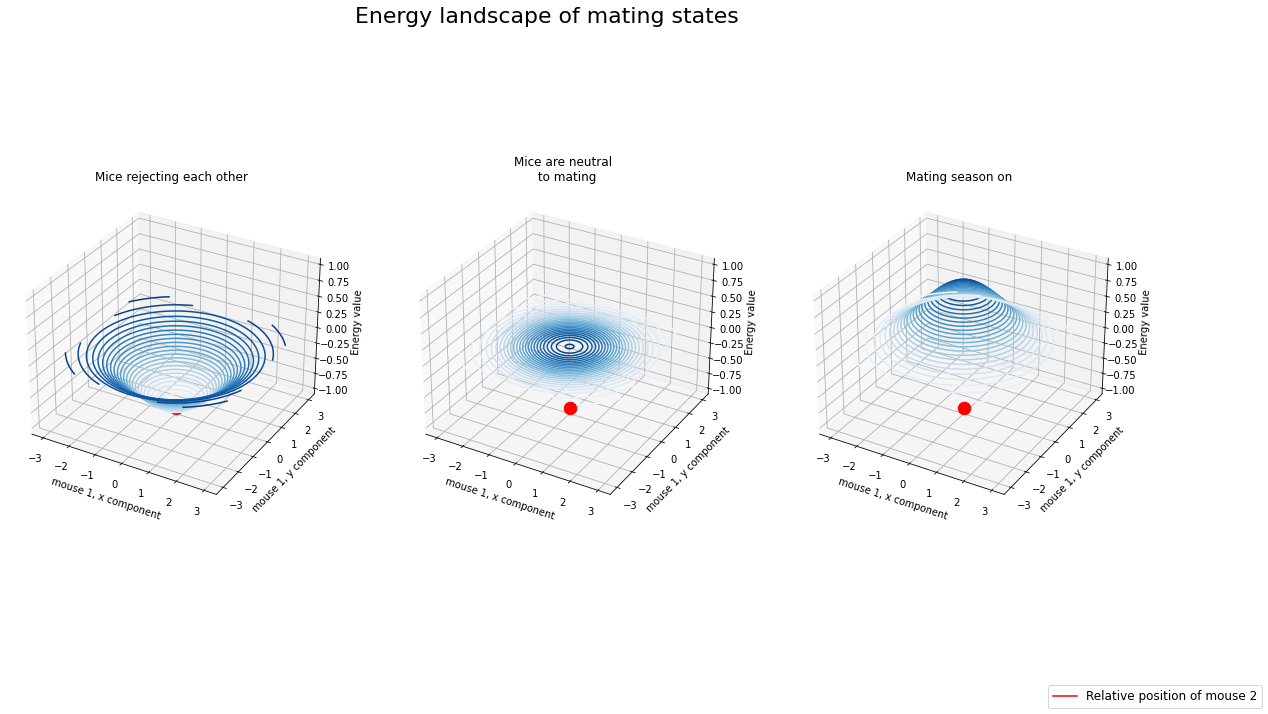

In [24]:
plot_mating_energy_landscape(figsize=(20,10))


As mentioned before, the dynamics of the system is to do gradient descent on this energy landscape

The gradient of mouse 1 then looks like

$$\frac{\partial {E_{mating}} }{\partial \vec{m1}}=(-1) \cdot \sin (w_{mating}t) \cdot \frac {2}{\sigma ^2} \cdot (\vec {m_1} - {\vec {m_2}})
\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma ^2 }) $$,

important being the fact that $\frac{\partial {E_{mating}}}{\partial \vec{m1}} \propto (\vec {m_1} - {\vec {m_2}}) $.

Depending on the value of $\sin (w_{mating}t)$ the system will either try to

1. reduce the distance between $\vec{m_1}$ and $\vec{m_2}$ in case $\sin (w_{mating}t) = 1 $, due the leading -1
2. increase the distance between $\vec{m_1}$ and $\vec{m_2}$ in case $\sin (w_{mating}t) = -1 $, for the same reason

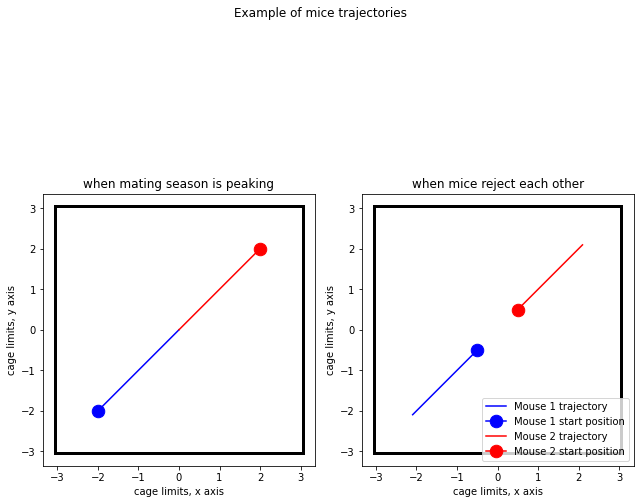

In [25]:
always_mating, always_rejecting = plot_mice_trajetories_for_mating_season_on_and_off()

One can also observe the evolution of the mating desire gradient length when mice
are closing in on each other.

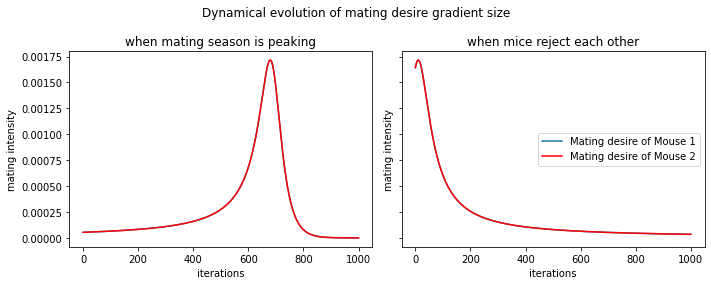

In [26]:
plot_mating_desire_gradients_for_mating_on_and_off(always_mating, always_rejecting)

As wanting to model, the closer
mice are to each other the higher the desire for mating.

#### Feeding Model

The feeding model is implemented with the same idea of an energy landscape as the **mating model** is.

Basically, I have modelled

$$E_{hunger} (t, \vec {m}) = {hunger_{max}} \cdot {\sigma}(t) \cdot || \vec {m} - \vec {food spot} || ^2$$

where

$$\sigma(t) = \frac {1} {1+ \exp(- \frac {t - (t_{lastfeeding} + 0.5 \cdot {t_{hunger}})}{slope})}$$

and $\vec {m}$ can be either $\vec {m_1}$ or $\vec {m_2}$ and $\vec {food spot}$ represents
the vector position of the center of the food spot considered from the centered of our
reference frame, the point $\vec {(0,0)}$

##### The strength of the hunger feeling

$\sigma(t)$ conveniently models how hungry a mouse is. I have chosen the sigmoidal function
because it can easily

1. model the fact that, with time, the mice get hungrier\
2. model the speed with which mice get hungrier by the parameter

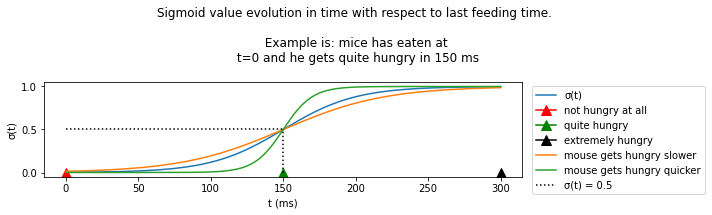

In [27]:
plot_sigmoid_function_output()

#### The gradient of the hunger feeling

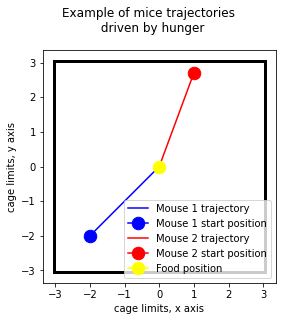

In [28]:
plot_feeding_example_trajectory()

### Implementation

The way the problem is declared allows me to split the problem into smaller ones.

#### Mice Model: combinining the three previous models

### Results
## Discussion